# [Building Powerful Image Classification Models Using Very Little Data](http://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html)
### [CHN: 面向小数据集构建图像分类模型](https://keras-cn-docs.readthedocs.io/zh_CN/latest/blog/image_classification_using_very_little_data/)
#### Errrneist, 20181019.

#### In this notebook, I will experiment with the following:
* Train a small network directly from image.
* Use features from the bottleneck from the pre-trained models. (Not sure about the pre-trained)
* Fine-Tune top layers of the pre-trained models.

#### The Keras features that I will be using:
* fit_generator for training Keras a model using Python data generators.
* ImageDataGenerator for real time data augumentation.
* Layer freezing and model fine-tuning.

#### The challenge:
* We are restricting us to 8% of the dataset, which makes the problem much harder, and more interesting to do.

## Data Pre-Processing and Data Augmentation

* I want to make the most of our few training examples.
* I will "augment" them with a number of random transformations.
* This helps with overfitting and helps the model generalize better.

#### [Decription]
In Keras, this can be done via the ```keras.preprocessing.image.ImageDataGenerator```class.

This class allows me to:
* Configure random transformations and normalization operations to be done on your image data during training.
* Instantiate generators of augumented image batches and their labels via ```.flow(data, labels)``` or ```.flow_from_directory(directory)```.
* These generators can then be used with the Keras model methods that accept data generators as inputs, ```fit_generator```, ```evaluate_generator```, and ```predict_generator```.

#### [Documentations]
* [ImageDataGenerator Documentation](http://keras.io/preprocessing/image/)
* [Shear Mapping](https://en.wikipedia.org/wiki/Shear_mapping)

#### [Explainations]
* Python Imaging Library (abbreviated as PIL) (in newer versions known as Pillow) is a free library for the Python programming language that adds support for opening, manipulating, and saving many different image file formats.

In [1]:
# Import Statement
import keras

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Create a ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
                            rotation_range=40,  # A value in degrees(0-180), random rotate pictures.
                            width_shift_range=0.2,  # A fraction of total width or height to translate images.
                            height_shift_range=0.2,  # Randomly translate heights.
                             rescale=1/.255,  # Scale the data to change the RGB values.
                             shear_range=0.2,  # Randomly applying sharing transformations.
                             zoom_range=0.2,  # Randomly zoom inside pictures.
                             horizontal_flip=True,  # Randomly flip HALF of the images horizontally.
                             fill_mode='nearest')  # Strategy to fill new pixels after a rotation/shift.


In [3]:
# Prepare Image
from keras.preprocessing import image
img = image.load_img('./DATA/small/train/cats/cat.0.jpg')  # A PIL image
x = image.img_to_array(img)  # This is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)  # This is a Numpy array with shape (1, 3, 140, 150)

In [4]:
# The .flow() command generates batches of randomly transformed images.
# They will be saved to the "preview/" directory.
i = 0
for batch in datagen.flow(x, batch_size = 1, 
                          save_to_dir = 'preview', save_prefix = 'cat', save_format = 'jpeg'):
    i += 1
    if i > 20:
        break  # Stop after 20 images


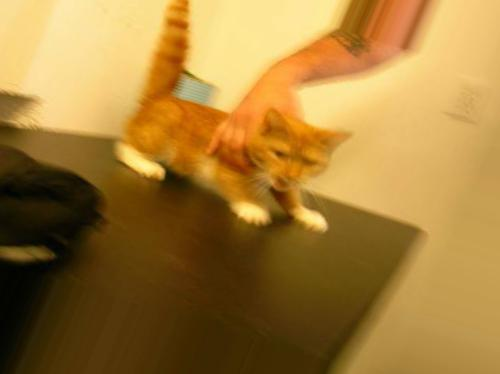

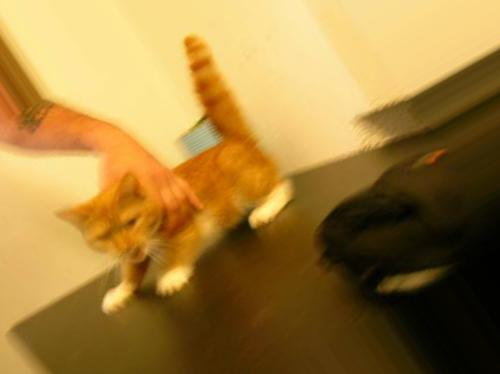

In [5]:
# This code segment will show images from the disk.
# Source: https://stackoverflow.com/questions/32370281/how-to-include-image-or-picture-in-jupyter-notebook

from IPython.display import Image
PATH = "./PREVIEW/"
IMAGE1="cat_0_3745.jpeg"
IMAGE2="cat_0_4903.jpeg"

def displayImage(path, filename):
    display(Image(filename = path + filename, width=150, height=150))
    
displayImage(PATH, IMAGE1)
displayImage(PATH, IMAGE2)

## Training a Small Convnet from Scratch
* One of our concerns is overfitting since we have so less samples.
* Data augmentation isn't enough to fight overfitting since it is still highly correlated.

### Build the Model

#### [Main Focus]
* MAIN focus: Entropic Capacity of the model.
* A model that can only store a few features will have to focus on the most significant features.
* These features are more likely to be truely relevant.
* Main way to modulate entropic capacity: choice of parameters of the model.
* Another way is to use weight regularization such as L1 or L2 regularization.

#### [Dropout]
* Dropout prevents a layer from seeing twice the exact same pattern.
* Both dropout and data augmentation tend to disrupt random correlations occuring in the data.

In [6]:
# First Model
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K

# Dimensions of our images
img_width, img_height = 150, 150

# Data directory
train_data_dir = './DATA/SMALL/TRAIN'
validation_data_dir = './DATA/SMALL/VALIDATION'
nb_train_samples = 2000
nb_validation_samples = 800
epochs = 50
batch_size = 16

# Check if images are of right format
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

# Magic command that fixes:
# ValueError: Negative dimension size caused by subtracting 2 from 1 for 'MaxPool_x'
# Source: https://github.com/keras-team/keras/issues/3945
K.set_image_dim_ordering('th')

In [7]:
model = Sequential()

# The model so far outputs 3D feature maps(height, width, features)
model.add(Conv2D(32, (3, 3), input_shape=(3, 150, 150)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

In [8]:
# This converts 3D feature maps to 1D feature maps.
model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))

model.add(Dropout(0.5))
model.add(Dense(1))  # For binary classification
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Prepare Data

In [9]:
# Define batch size
batch_size = 16

# Define augumentation configuration for training:
train_datagen = ImageDataGenerator(
    rescale = 1./255,  # We used a 1. here to make sure rescale comes out as float
    shear_range=0.2, 
    zoom_range=0.2, 
    horizontal_flip=True)

In [10]:
# Define augmentation configuration for testing:
test_datagen = ImageDataGenerator(rescale=1./255)

In [11]:
# This is a generator that will read pictures found in 'data/train' 
# and indefinitely generate batches of augmented image data.
train_generator = train_datagen.flow_from_directory(
    './DATA/SMALL/TRAIN/',  # Target directory.
    target_size = (150, 150),  # All images will be resized to 150x150
    batch_size = batch_size,  # Define batch size (redundant?)
    class_mode='binary')  # Since we use binary_crossentropy

# A generator for validation data
validation_generator = test_datagen.flow_from_directory(
    './DATA/SMALL/VALIDATION/', 
    target_size = (150, 150), 
    batch_size = batch_size, 
    class_mode = 'binary')

Found 2002 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [53]:
# Fit Model
model.fit_generator(
    train_generator, 
    steps_per_epoch=2000 // batch_size,
    epochs=50, 
    validation_data = validation_generator, 
    validation_steps = 800 // batch_size)

# Save Weights
model.save_weights('first_try.h5')

Epoch 1/50
125/125 [==============================] - 146s 1s/step - loss: 0.7005 - acc: 0.5300 - val_loss: 0.6651 - val_acc: 0.5637
Epoch 2/50
125/125 [==============================] - 141s 1s/step - loss: 0.6601 - acc: 0.6190 - val_loss: 0.6297 - val_acc: 0.6587
Epoch 3/50
125/125 [==============================] - 146s 1s/step - loss: 0.6379 - acc: 0.6630 - val_loss: 0.5883 - val_acc: 0.6700
Epoch 4/50
125/125 [==============================] - 157s 1s/step - loss: 0.6032 - acc: 0.6845 - val_loss: 0.5498 - val_acc: 0.7137
Epoch 5/50
125/125 [==============================] - 150s 1s/step - loss: 0.5759 - acc: 0.7120 - val_loss: 0.6018 - val_acc: 0.6937
Epoch 6/50
125/125 [==============================] - 145s 1s/step - loss: 0.5688 - acc: 0.7120 - val_loss: 0.5376 - val_acc: 0.7188
Epoch 7/50
125/125 [==============================] - 147s 1s/step - loss: 0.5661 - acc: 0.7270 - val_loss: 0.5374 - val_acc: 0.7338
Epoch 8/50
125/125 [==============================] - 154s 1s/step - 

## Using Bottleneck Features of a Pre-Trained Network
* We will use the VGG16 architecture, pre-trained on the ImageNet dataset.

In [11]:
# Save bottleneck fratures
from keras import applications
import numpy as np

# Using parameters from last model
top_model_weights_path = 'bottleneck_fc_model.h5'

batch_size = 16
# Dimensions of our images
img_width, img_height = 150, 150

# Data directory
train_data_dir = './DATA/SMALL/TRAIN/'
validation_data_dir = './DATA/SMALL/VALIDATION/'

datagen = ImageDataGenerator(rescale=1. / 255)

# Build the VGG16 network
model = applications.VGG16(include_top = False, weights='imagenet')

generator = datagen.flow_from_directory(
    train_data_dir, 
    target_size=(img_width, img_height), 
    batch_size=batch_size, 
    class_mode=None,  # This means our generator will only yield batches of data, no labels.
    shuffle=False)  # Data will be in order, so all first 1000 are cats and then 1000 dogs.

# The predict_generator method returns output of a model, 
# given a generator that yields batches of numpy data.
# Note: Verbose=1 gives the progress bar.
bottleneck_features_train = model.predict_generator(generator, 2000, verbose=1)

# Save the output as a numpy array
# Note: If you are using Windows, you must use the binary 'b' modes when saving numpy array.
# Source: https://gist.github.com/fchollet/f35fbc80e066a49d65f1688a7e99f069
np.save(open('bottleneck_features_train.npy', 'wb'), bottleneck_features_train)

Found 2002 images belonging to 2 classes.
2000/2000 [==============================] - 127s 64ms/step


In [16]:
# Save validation weights
generator = datagen.flow_from_directory(
    validation_data_dir, 
    target_size=(img_width, img_height), 
    batch_size=batch_size, 
    class_mode=None,  # This means our generator will only yield batches of data, no labels.
    shuffle=False)  # Data will be in order, so all first 1000 are cats and then 1000 dogs.

# The predict_generator method returns output of a model, 
# given a generator that yields batches of numpy data.
bottleneck_features_validation = model.predict_generator(generator, 800, verbose=1)

# Save the output as a numpy array
np.save(open('bottleneck_features_validation.npy', 'wb'), bottleneck_features_validation)

Found 800 images belonging to 2 classes.
800/800 [==============================] - 400s 500ms/step


In [8]:
# Load data and labels
# Note: Also, we need to add a 'rb' argument otherwise it won't run.
train_data = np.load(open('bottleneck_features_train.npy', 'rb'))
train_labels = np.array([0] * 1000 + [1] * 1000)

validation_data = np.load(open('bottleneck_features_validation.npy', 'rb'))
validation_labels = np.array([0] * 400 + [1] * 400)

In [12]:
train_labels.shape

(2000,)

In [13]:
# Construct model
model = Sequential()
model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Train top model
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(train_data, train_labels, epochs=50, batch_size=batch_size, validation_data=(validation_data, validation_labels))

model.save_weights('bottleneck_fc_model.h5')

ValueError: Input 0 is incompatible with layer flatten_2: expected min_ndim=3, found ndim=2

In [ ]:
top_model_weights_path = './vgg16_weights.h5'
# Build a classifier model to put on top of the convolutional model
top_model = Sequential()
top_model.add(Flatten(input_shape=model.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(1, activation='sigmoid'))

# Note that it is necessary to start with a fully trained classifier, including the top classifier
# in order to successfully do fine tuning.
top_model.load_weights(top_model_weights_path)

# Add the model on top of the convolutional base
model.add(top_model)